# Model and Visualisation File for Challenge 02

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle5 as pickle
import seaborn as sns
import datetime
import time
import scipy
import json

import importlib
import reverse_xfm
importlib.reload(reverse_xfm)
from reverse_xfm import reverse_samples_for_analysis, xfm_data_for_modelling, convert_to_mt103

import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.mixture import GaussianMixture as GMM
from transformer import DataTransformer

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from data_analyser import DataAnalyser

In [2]:
dirlist = ['models', 'data']

for dir_ in dirlist:
    try:
        os.makedirs(dir_)
    except:
        print(f'Could not make directory {dir_}')

Could not make directory models
Could not make directory data


In [3]:
df = pd.read_csv('data/hackathon_parsed_format_a.csv')

##### Use this variable to run a smaller sample

In [4]:
run_sample = True

In [5]:
%%time
if run_sample:
    df, data = xfm_data_for_modelling(df[:1000])
else:
    df, data = xfm_data_for_modelling(df)

Saving source data prepared for modeling..
CPU times: user 48.7 ms, sys: 7.72 ms, total: 56.4 ms
Wall time: 55.6 ms


In [6]:
df['send_rec_pair'] = df['52a_sender'] + df['57a_receiver']

In [7]:
data

,33b_cur,usd_amt,src_xfrr_type,src_lon,send_rec_pair,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,21290.802177,A,0.000000,BIC68DF2C94BIC6A94AE24,0.000000,34.146942,-118.247847,SHA,999,0.0
1,RUB,12576.048111,A,0.000000,BIC68DF2C94BIC6A94AE24,0.000000,47.566422,-99.650882,BEN,RUB,0.0
2,RUB,300040.925852,A,0.000000,BIC68DF2C94BIC6A94AE24,0.000000,42.795605,-110.929451,SHA,999,0.0
3,RUB,12114.363523,A,0.000000,BIC68DF2C94BIC6A94AE24,0.000000,35.815612,-101.910435,SHA,999,0.0
4,RUB,92332.394587,A,0.000000,BIC68DF2C94BIC6A94AE24,0.000000,27.547259,-81.811471,SHA,999,0.0
...,...,...,...,...,...,...,...,...,...,...,...
995,RUB,20945.836712,A,0.000000,BIC68DF2C94BIC6A94AE24,0.000000,40.199300,-93.114099,SHA,999,0.0
996,RUB,1873.846452,K,-70.713501,BIC68DF2C94BIC6A94AE24,44.055025,42.000858,-92.198521,BEN,RUB,0.0
997,RUB,8373.954231,A,0.000000,BIC68DF2C94BIC6A94AE24,0.000000,20.763395,-156.446400,OUR,999,0.0
998,RUB,8071.732973,K,-84.497039,BIC68DF2C94BIC6A94AE24,38.046407,31.869631,-82.594303,SHA,999,0.0


In [8]:
def get_input_data(neg_cond = None):
    """ Helps to select payor type ['A', 'F', 'K'] data from actual dataset. """
    if neg_cond is None:
        input_data = data[data['src_xfrr_type'] == 'A']
        sfx = '_a'
    else:
        input_data = data[data['src_xfrr_type'] != 'A']
        sfx = '_fk'
    return input_data, sfx

## Model for 50A payors of type 'F' and 'K' 

In [9]:
%%time
input_data, sfx = get_input_data(neg_cond = 'A')
xfm_datafile = f"data/xfm_datafile{sfx}.csv"
xfm_model = f"models/gan_transformer{sfx}.pkl"
gmm_model = f"models/gmm_model{sfx}.pkl"
reload_data = True
retrain = True

n_components = 15

CPU times: user 1.33 ms, sys: 117 µs, total: 1.45 ms
Wall time: 1.25 ms


In [10]:
%%time
print(datetime.datetime.now())
discrete = [col for col in input_data.columns if col not in input_data._get_numeric_data().columns]

2021-09-24 09:23:09.694433
CPU times: user 1.13 ms, sys: 0 ns, total: 1.13 ms
Wall time: 884 µs


In [11]:
%%time
print(datetime.datetime.now())

if reload_data:
    transformer = DataTransformer()
    transformer.fit(input_data, discrete)
    data_xfk = transformer.transform(input_data)
    pd.DataFrame(data_xfk).to_csv(xfm_datafile, index=False)
    pickle.dump(transformer, open(xfm_model, 'wb'))
else:
    print(f"Loading Datafile: {xfm_datafile} and Transformer: {xfm_model} !!")
    data_ = pd.read_csv(xfm_datafile).to_numpy()
    transformer = pickle.load(open(xfm_model, 'rb'))

2021-09-24 09:23:09.700304
CPU times: user 816 ms, sys: 8 ms, total: 824 ms
Wall time: 823 ms


## Gaussian Mixture Model
- Number pf components/clusters = 15
- covariance type = 'Full'

Models a sample space to capture corrlation across attributes

In [12]:
%%time
print(datetime.datetime.now())
if retrain:
    synthesizer_fk = GMM(n_components = n_components, covariance_type = "full", random_state = 0)
    synthesizer_fk.fit(data_xfk)
    print("Training completed. Saving the model file !")
    pickle.dump(synthesizer_fk, open(gmm_model, 'wb'))
else:
    synthesizer_fk = pickle.load(open(gmm_model, 'rb'))

2021-09-24 09:23:10.528039
Training completed. Saving the model file !
CPU times: user 768 ms, sys: 957 ms, total: 1.73 s
Wall time: 468 ms


#### Sample records for type 'F' and 'K'

In [13]:
num_samples = 7000

In [14]:
%%time
print(datetime.datetime.now())
samples_xfk = synthesizer_fk.sample(num_samples)
samples_fk = transformer.inverse_transform(samples_xfk[0])

2021-09-24 09:23:11.081834
CPU times: user 329 ms, sys: 310 ms, total: 639 ms
Wall time: 204 ms


In [15]:
%%time
samples_fk = reverse_samples_for_analysis(samples_fk, sfx = sfx, model_type = 'gmm')

Time elasped for 50f_payor_add_ln_2 = 0.000800421999883838
Time elasped for src_xfrr_type = 2.4604643729999225
Time elasped for 50f_payor_add_lat = 0.002728906999436731
Time elasped for 50f_payor_add_lon = 0.01606358699973498
Time elasped for 50k_payor_add_lat = 0.0015979299996615737
Time elasped for 50k_payor_add_lon = 0.0012985479997951188
Time elasped for 50k_payor_add_ln_2 = 0.0004244089996063849
Time elasped for 50k_payor_add_ln_2 = 2.65983913799937
Time elasped for 59f_ben_add_ln_2 = 3.4779738639999778
Time elasped for 59f_ben_add_lat = 0.0010502129998712917
Time elasped for 59f_ben_add_lon = 0.0008115460004773922
Time elasped for 71A_chg_dtls = 0.0007336200005738647
Time elasped for 71f_chg_dtls_cur = 0.0014593120004064986
Time elasped for 71f_chg_dtls_amt = 0.00449488000049314
CPU times: user 298 ms, sys: 248 ms, total: 545 ms
Wall time: 8.77 s


In [16]:
samples_fk

,33b_cur,usd_amt,src_xfrr_type,src_lon,send_rec_pair,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,...,50f_payor_add_lon,50k_payor_add_lat,50k_payor_add_lon,50k_payor_add_ln_2,59f_ben_add_ln_2,59f_ben_add_lat,59f_ben_add_lon,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,RUB,47628.899897,F,-90.834737,BIC6A94AE24BIC68DF2C94,41.160326,38.782762,-95.895206,OUR,999,...,-90.834737,0.000000,0.000000,,US MOORHEAD,38.782762,-95.895206,OUR,999,0.000000e+00
1,RUB,55925.499123,F,-91.936782,BIC68DF2C94BIC6A94AE24,43.915340,41.652110,-108.649632,OUR,999,...,-91.936782,0.000000,0.000000,,US SAN ELIZARIO,41.652110,-108.649632,OUR,999,7.766449e-06
2,RUB,38215.330151,F,-122.469560,BIC68DF2C94BIC6A94AE24,40.844996,37.931920,-118.502893,OUR,999,...,-122.469560,0.000000,0.000000,,US KALAMA,37.931920,-118.502893,OUR,999,0.000000e+00
3,RUB,73658.025492,F,-89.490970,BIC68DF2C94BIC6A94AE24,40.738669,36.938836,-92.158685,OUR,999,...,-89.490970,0.000000,0.000000,,US CALICO ROCK,36.938836,-92.158685,OUR,999,0.000000e+00
4,RUB,25775.963510,F,-75.739287,BIC68DF2C94BIC6A94AE24,42.797847,41.143509,-113.371405,SHA,999,...,-75.739287,0.000000,0.000000,,US ORACLE,41.143509,-113.371405,SHA,999,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,RUB,6884.381204,K,-76.649061,BIC68DF2C94BIC6A94AE24,43.157949,43.846635,-71.038974,OUR,999,...,0.000000,43.157949,-76.649061,US GASBURG,US WESTFORD,43.846635,-71.038974,OUR,999,6.429852e-08
6996,RUB,-3719.912435,F,-84.718287,BIC68DF2C94BIC6A94AE24,39.218841,55.357743,-81.005217,OUR,999,...,-84.718287,0.000000,0.000000,,US CENTER LINE,55.357743,-81.005217,OUR,999,2.770224e-06
6997,RUB,5973.397925,K,-113.932484,BIC68DF2C94BIC6A94AE24,24.375281,34.872791,-91.636309,OUR,999,...,0.000000,24.375281,-113.932484,US OLYMPIA,US BELLE,34.872791,-91.636309,OUR,999,0.000000e+00
6998,RUB,22043.654680,K,-72.095966,BIC68DF2C94BIC6A94AE24,38.929715,32.314905,-90.129699,OUR,999,...,0.000000,38.929715,-72.095966,US ALLSTON,US CROWDER,32.314905,-90.129699,OUR,999,1.442558e-06


### Data Analysis and Visualisation
Transaction Source Types - 'F' and 'K'

In [17]:
def pdist(x):
    """ Converts a set of values to prob distribution. """
    v = pd.DataFrame(x).value_counts()
    z = np.array([v.to_dict()[x]/v.sum() for x in v.to_dict().keys()])
    return z

def multivariate_kl(data, samples, model):
    """ This function evaluates relatie entropy for probabilty distributions given by 
        gaussian mixture model on actual data and sample data.
    
        Gaussian mixture model fitted on actual data is used to predcit labels for actual 
        and sampled data and the labels are then converted to probabilty distributions to 
        check how close they are.

    """
    data_labels = model.predict(data_xfk)
    samples_labels = model.predict(samples_xfk[0])
    
    klscore = scipy.special.kl_div(pdist(data_labels), pdist(samples_labels)).sum()
    print()
    print(f"Multivariate KL Divergence score for two datasets : \x1b[1;31m {klscore} \x1b[0m")
    print()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    ax = axes[0]
    sns.distplot(data_labels, ax = axes[0])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.set_title('Original Data')
    ax = axes[1]
    sns.distplot(samples_labels, ax = axes[1])
    ax.set_title('Synthetic Data')
    plt.show()

def attr_plot(data, samples, discrete = None, numeric = None):
    sns.set(style='whitegrid')
    if discrete is None:
        for col in numeric:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.distplot(data[col], bins=100, hist_kws={'alpha': 0.7})
            plt.subplot(122)
            sns.distplot(samples[col], bins=100, hist_kws={'alpha': 0.7})
    else:
        for col in discrete:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.countplot(x=col, data=data[discrete])
            plt.xticks(rotation=45)
            plt.subplot(122)
            sns.countplot(x=col, data=samples[discrete])
            plt.xticks(rotation=45)

def corrplot(data, samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(data.corr(), annot=True, cmap="Blues", vmin = -0.5, vmax = 0.5)
    
    plt.subplot(122)
    sns.heatmap(samples.corr(), annot=True, cmap="Blues", vmin = -0.5, vmax = 0.5)

discrete = ['33b_cur', 'src_xfrr_type', 'charge_dtls', 'charge_dtls_cur', 'send_rec_pair']
numeric = ['usd_amt', 'src_lon', 'src_lat', 'target_lat', 'target_lon', 'charge_dtls_amt']

##### KL Divergence

###### Multivariate


Multivariate KL Divergence score for two datasets :  0.0006061590655726465 



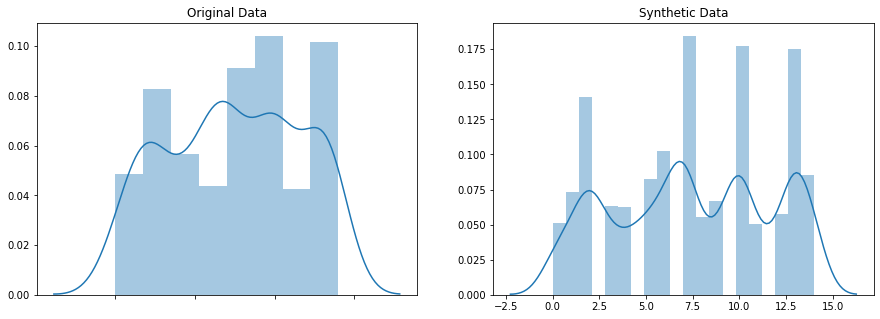

In [18]:
multivariate_kl(data_xfk, samples_xfk[0], synthesizer_fk)

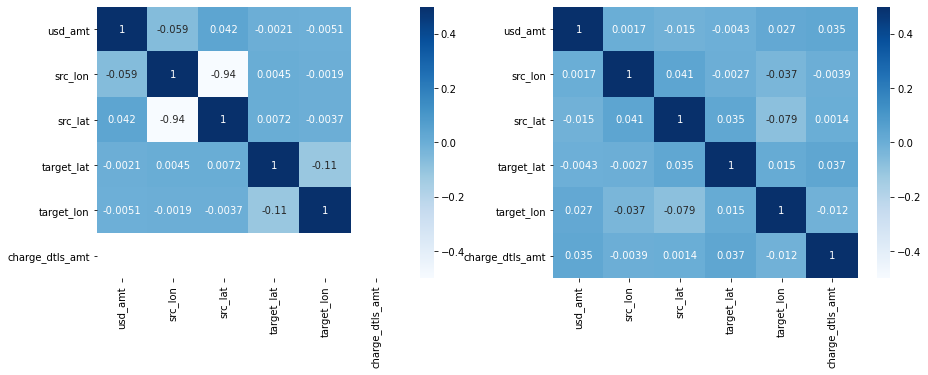

In [19]:
corrplot(df[numeric], samples_fk[numeric])

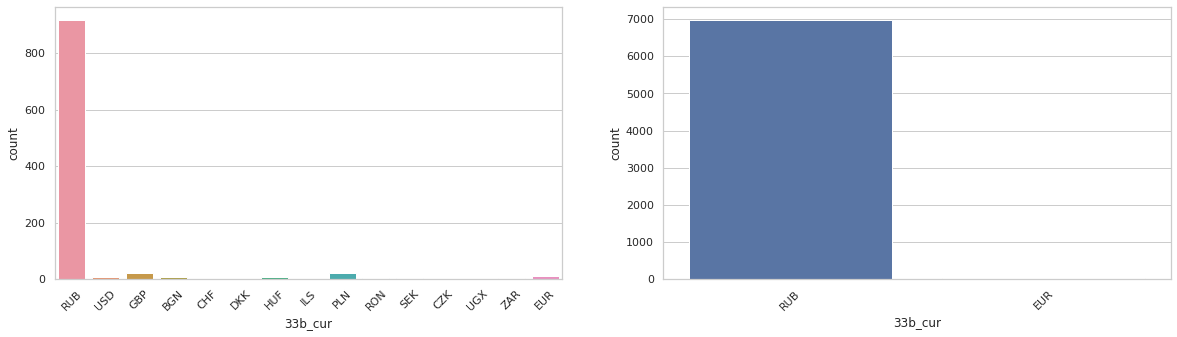

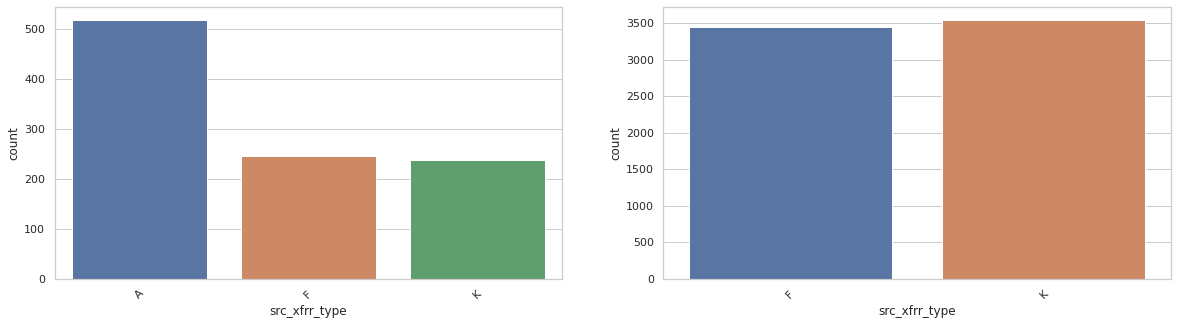

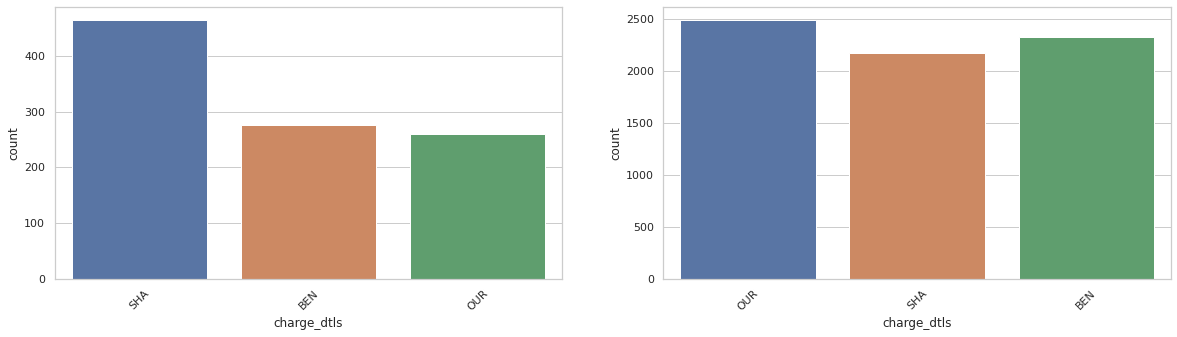

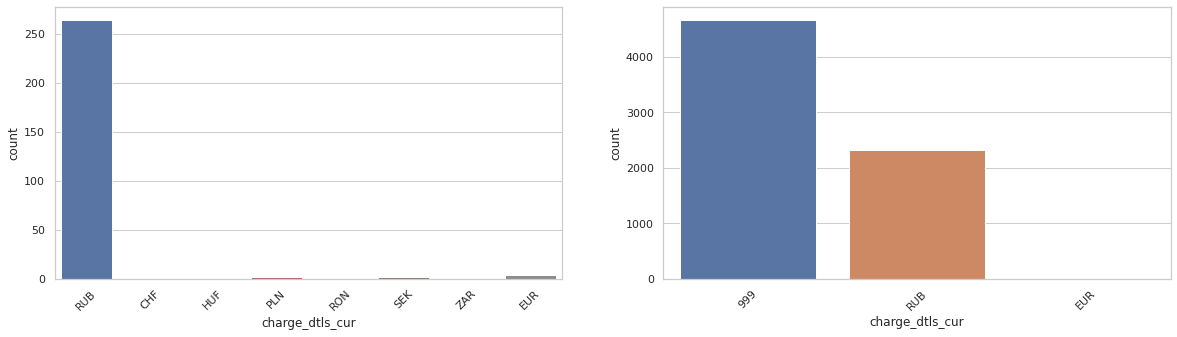

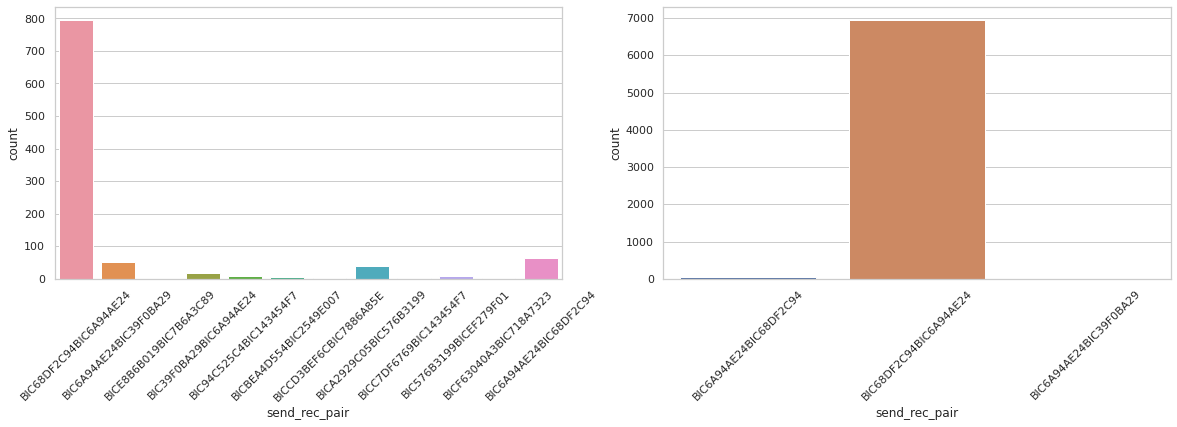

In [20]:
attr_plot(df, samples_fk, discrete = discrete)

#### Univariate numerical distribution

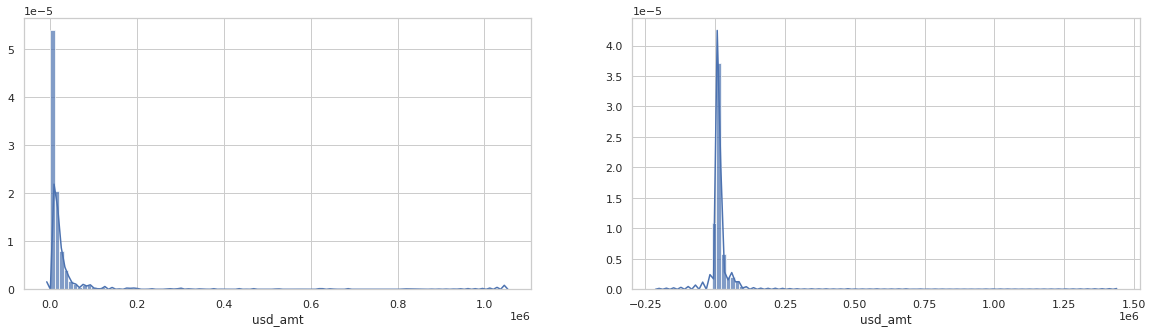

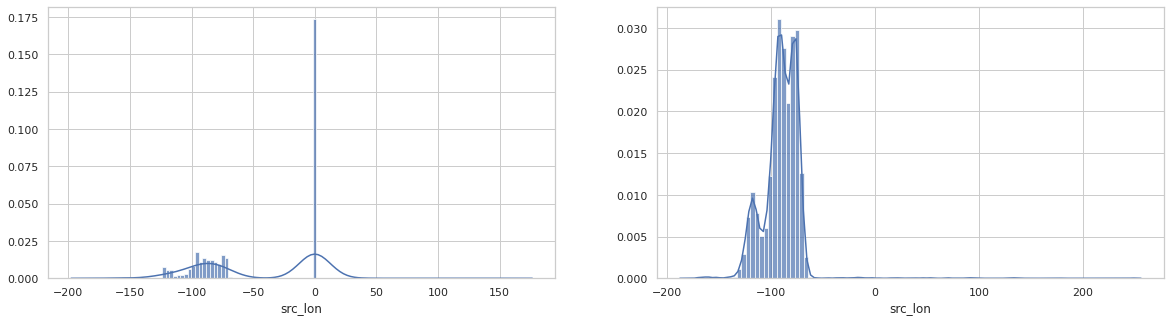

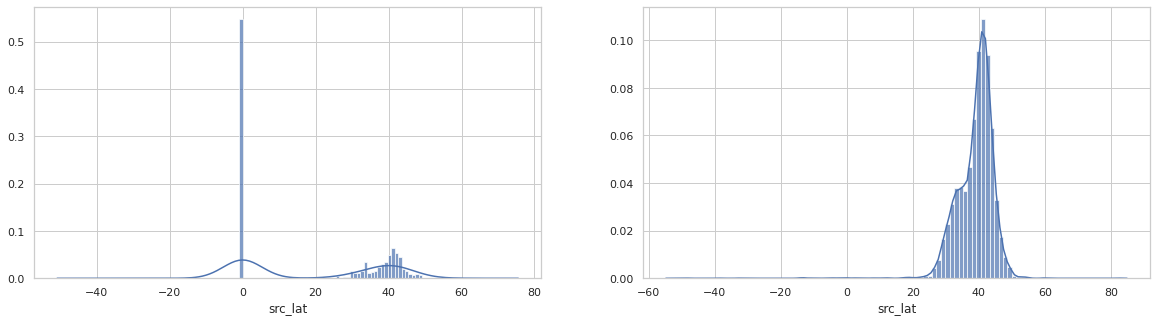

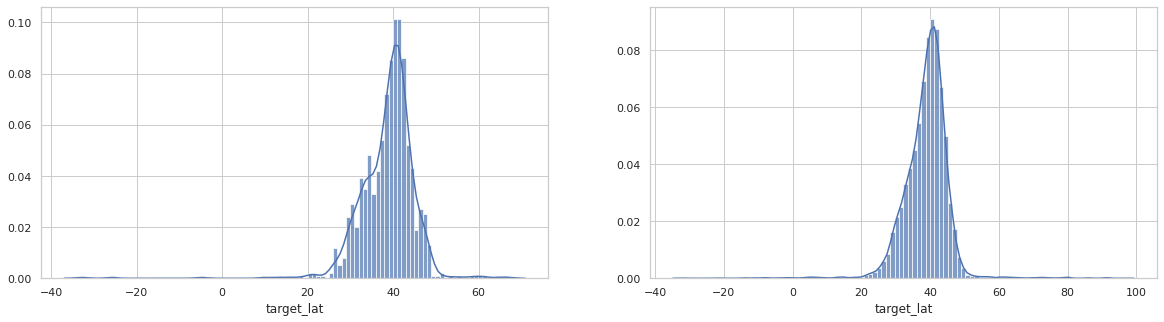

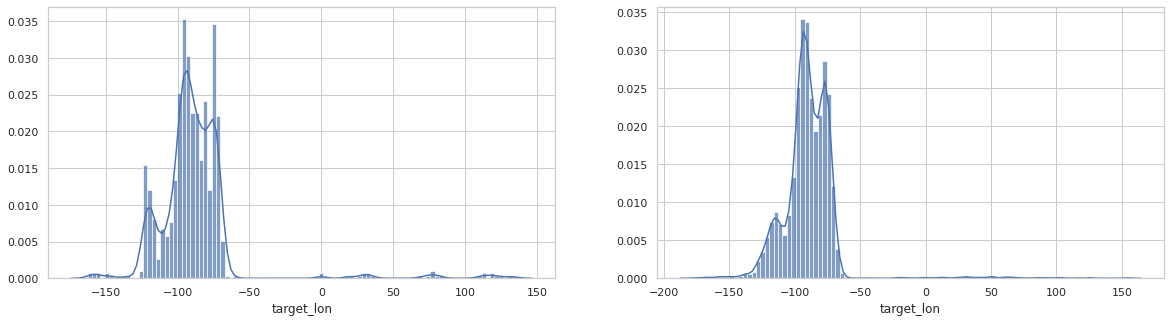

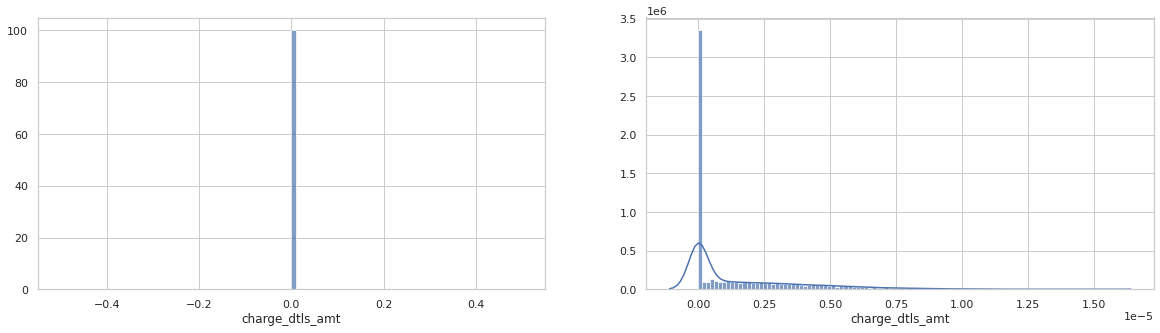

In [21]:
attr_plot(df, samples_fk, numeric = numeric)

In [22]:
datan = DataAnalyser(df, samples_fk)

##### Currency distribution in top 100 transactions

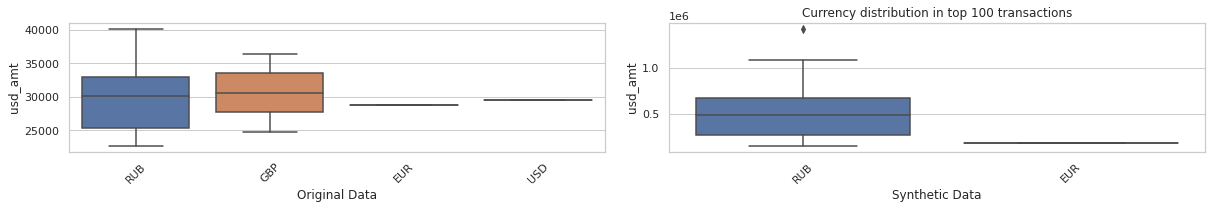

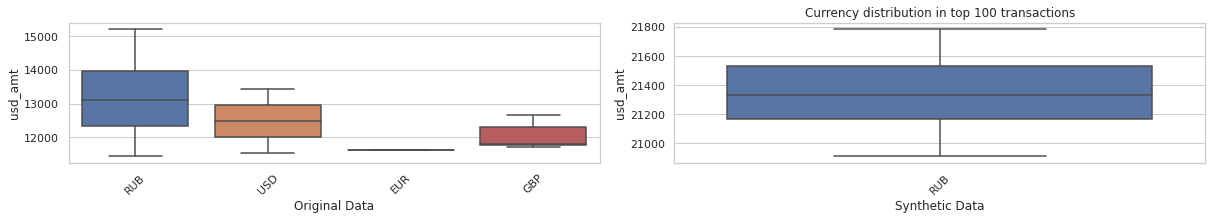

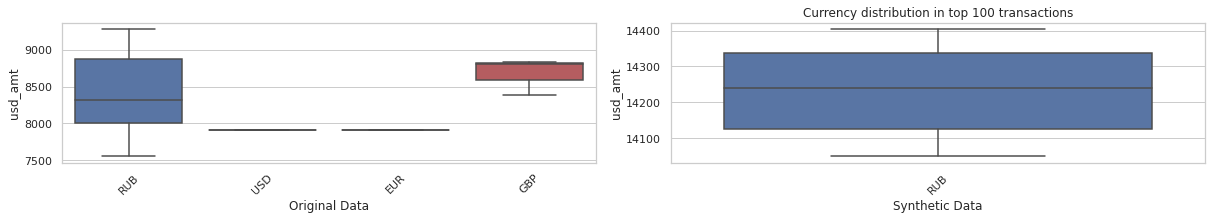

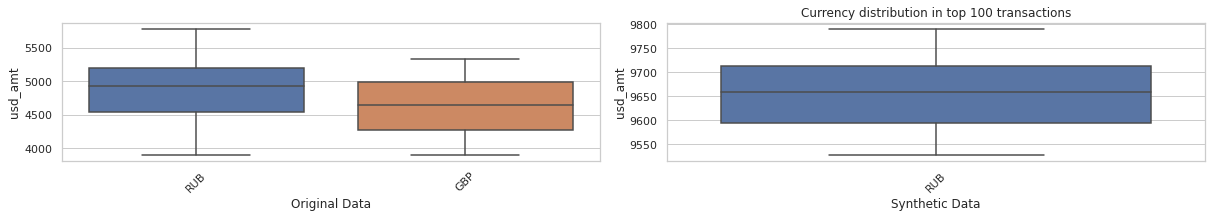

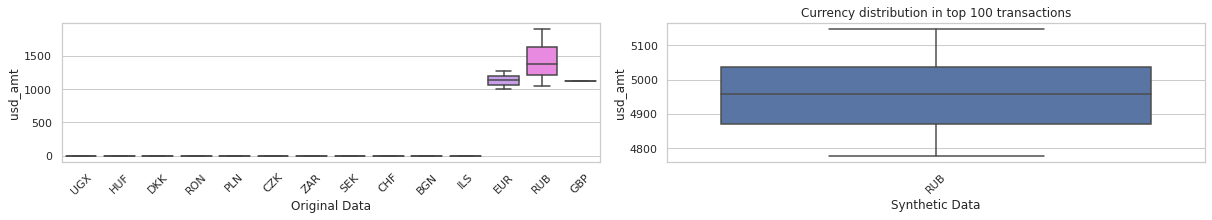

In [23]:
datan.plot_transaction_distribution(bins = 5, value_col = 'usd_amt', top_n = 100)

#### Top transactions hotspots

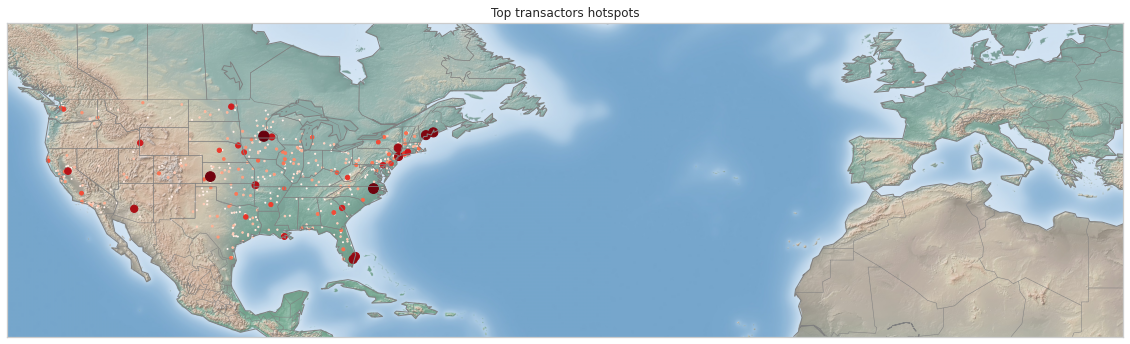

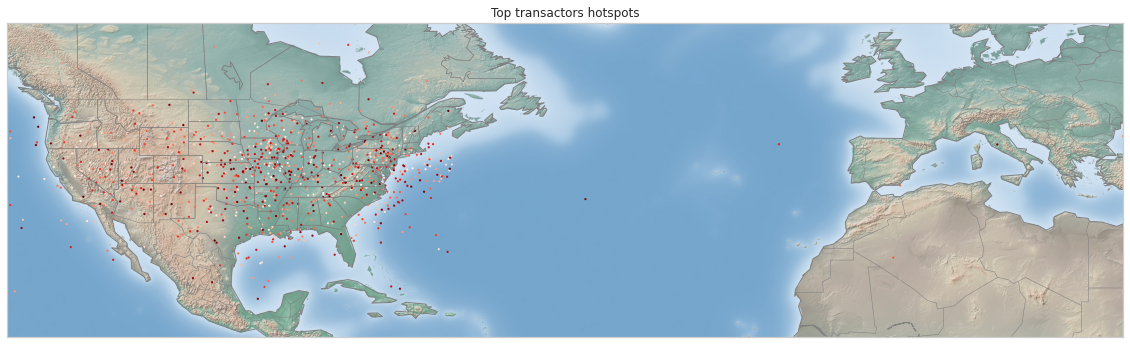

In [24]:
# original data comes first followed by the synthetically generated data
lower_bound_percentile = 0.5 
datan.plot_analysis(lower = lower_bound_percentile, transactor = 'target', value_col = 'usd_amt')

##### PCA Analysis

In [44]:
cov_samples_xfk = samples_xfk[0].T.dot(samples_xfk[0])
Us, ss, Vts = np.linalg.svd(cov_samples_xfk)

In [45]:
cov_data_xfk = data_xfk.T.dot(data_xfk)
Ud, sd, Vtd = np.linalg.svd(cov_data_xfk)

##### Cosine similarity between top principal components

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

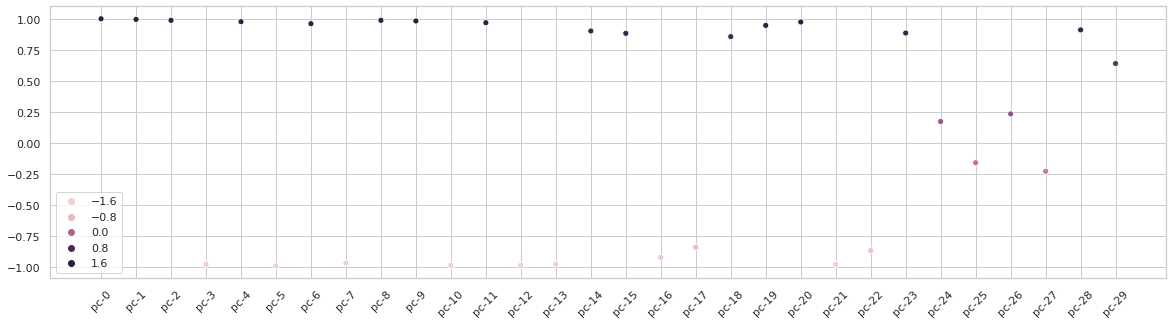

In [53]:
## Check cosine similarity between principal components
n_components = 30
x = ['pc-'+str(i) for i in range(n_components)]
y = [Us[:, i].dot(Ud[:, i]) for i in range(n_components)]

plt.figure(figsize=(20, 5))
sns.scatterplot(x, y, hue=y)
plt.xticks(rotation=45)

### Train model with transaction of type Payor -> 'A'

In [25]:
%%time
input_data, sfx = get_input_data()
xfm_datafile = f"data/xfm_datafile{sfx}.csv"
xfm_model = f"models/gan_transformer{sfx}.pkl"
gmm_model = f"models/gmm_model{sfx}.pkl"
reload_data = True
retrain = True

n_components = 15

CPU times: user 1.4 ms, sys: 297 µs, total: 1.7 ms
Wall time: 1.23 ms


In [26]:
%%time
print(datetime.datetime.now())

if reload_data:
    transformer = DataTransformer()
    transformer.fit(input_data, discrete)
    data_xa = transformer.transform(input_data)
    pd.DataFrame(data_xa).to_csv(xfm_datafile, index=False)
    pickle.dump(transformer, open(xfm_model, 'wb'))
else:
    print(f"Loading Datafile: {xfm_datafile} and Transformer: {xfm_model} !!")
    data_ = pd.read_csv(xfm_datafile).to_numpy()
    transformer = pickle.load(open(xfm_model, 'rb'))

2021-09-24 09:23:36.563023
CPU times: user 759 ms, sys: 0 ns, total: 759 ms
Wall time: 757 ms


In [27]:
%%time
print(datetime.datetime.now())
if retrain:
    synthesizer = GMM(n_components = n_components, covariance_type = "full", random_state = 0)
    synthesizer.fit(data_xa)
    print("Training completed. Saving the model file !")
    pickle.dump(synthesizer, open(gmm_model, 'wb'))
else:
    synthesizer = pickle.load(open(gmm_model, 'rb'))

2021-09-24 09:23:37.325416
Training completed. Saving the model file !
CPU times: user 1.32 s, sys: 1.7 s, total: 3.02 s
Wall time: 952 ms


#### Sample records for type 'A' records

In [28]:
num_samples = 2300

In [29]:
%%time
print(datetime.datetime.now())
samples_xa = synthesizer.sample(num_samples)
samples_a = transformer.inverse_transform(samples_xa[0])

2021-09-24 09:23:38.294671
CPU times: user 343 ms, sys: 645 ms, total: 988 ms
Wall time: 383 ms


In [30]:
%%time
samples_a = reverse_samples_for_analysis(samples_a, sfx = sfx, model_type = 'gmm')

Time elasped for 50f_payor_add_ln_2 = 0.001919779000672861
Time elasped for src_xfrr_type = 0.10911860299984255
Time elasped for 50f_payor_add_lat = 0.002347981999264448
Time elasped for 50f_payor_add_lon = 0.0009507380000286503
Time elasped for 50k_payor_add_lat = 0.0009968750000552973
Time elasped for 50k_payor_add_lon = 0.0008586390003983979
Time elasped for 50k_payor_add_ln_2 = 0.00039616799949726555
Time elasped for 50k_payor_add_ln_2 = 0.07924096599981567
Time elasped for 59f_ben_add_ln_2 = 1.250950312999521
Time elasped for 59f_ben_add_lat = 0.0005901860004087212
Time elasped for 59f_ben_add_lon = 0.0005769059998783632
Time elasped for 71A_chg_dtls = 0.0012375349997455487
Time elasped for 71f_chg_dtls_cur = 0.0021041440004410106
Time elasped for 71f_chg_dtls_amt = 0.035968013999990944
CPU times: user 129 ms, sys: 237 ms, total: 366 ms
Wall time: 1.53 s


### Data Analysis and Visualisation
Transaction Source Types - 'A'

##### KL Divergence

###### Multivariate


Multivariate KL Divergence score for two datasets :  0.0006061590655726465 



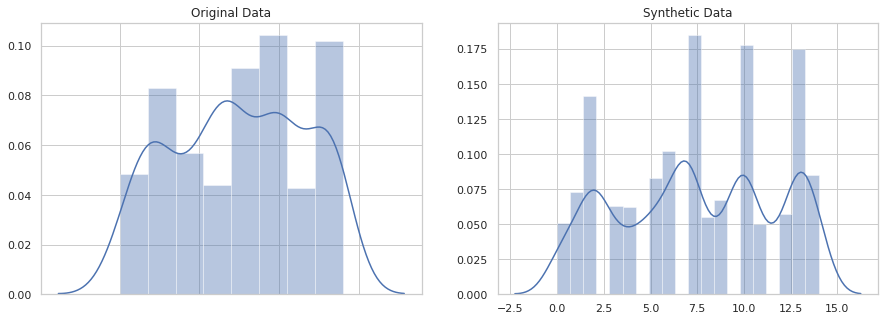

In [31]:
multivariate_kl(data_xfk, samples_xa[0], synthesizer_fk)

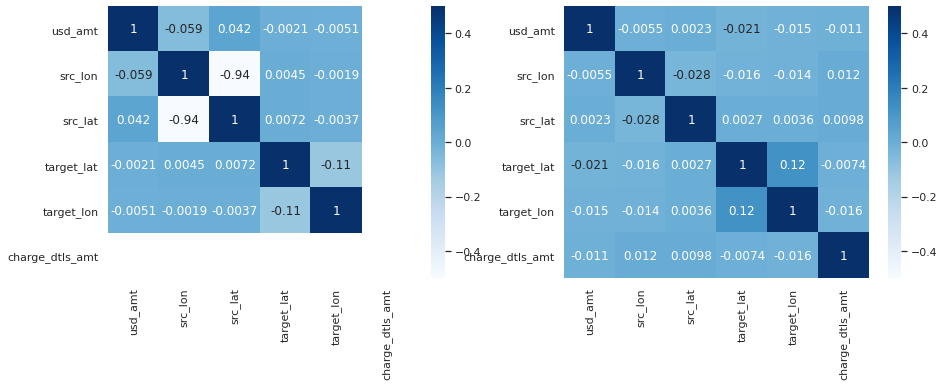

In [32]:
corrplot(df[numeric], samples_a[numeric])

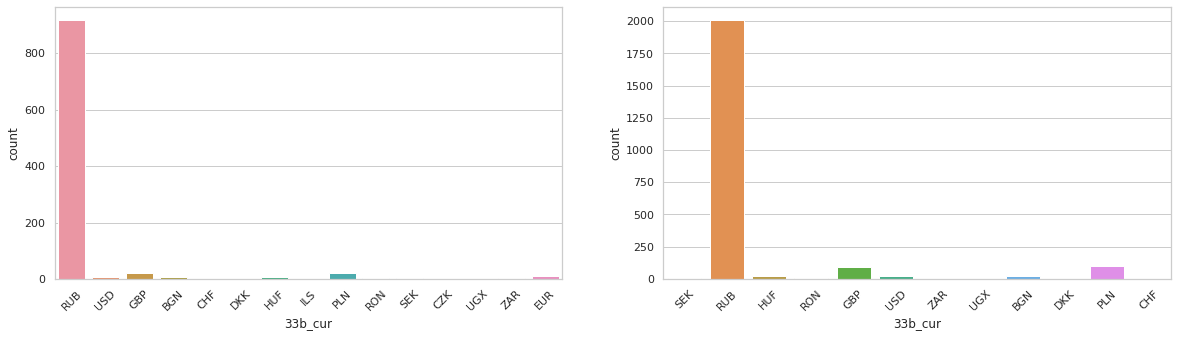

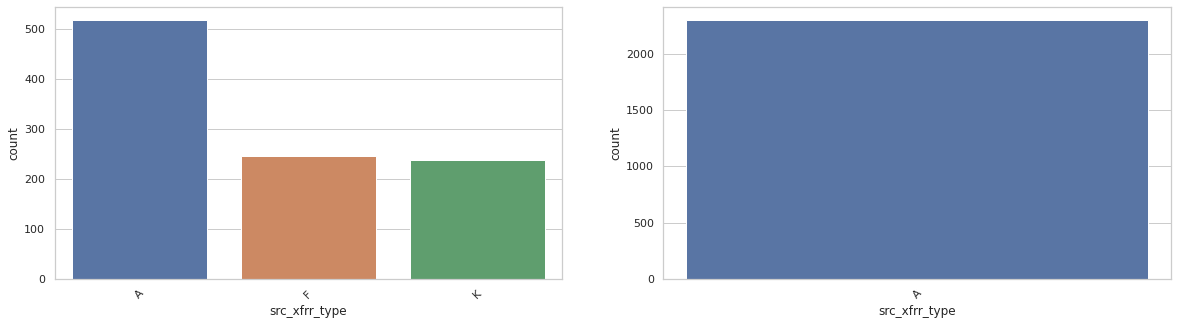

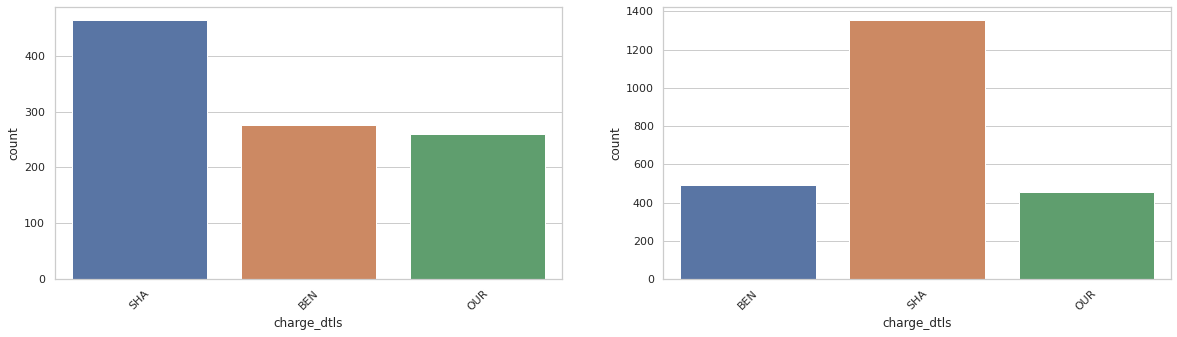

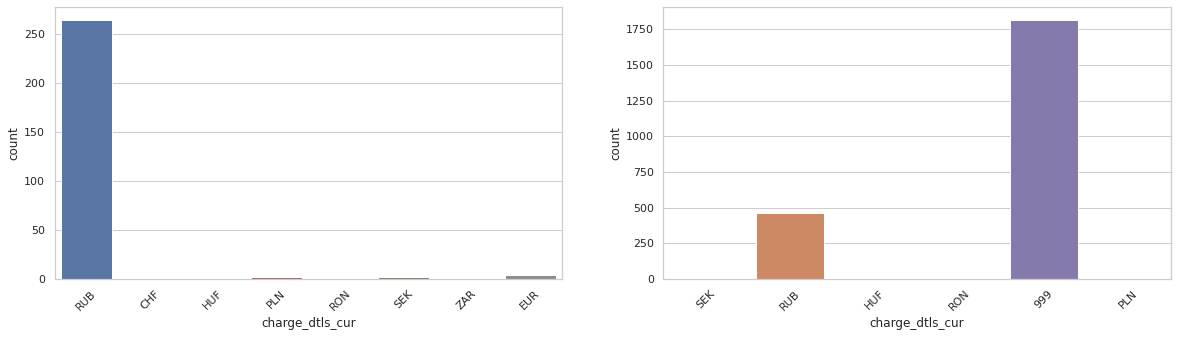

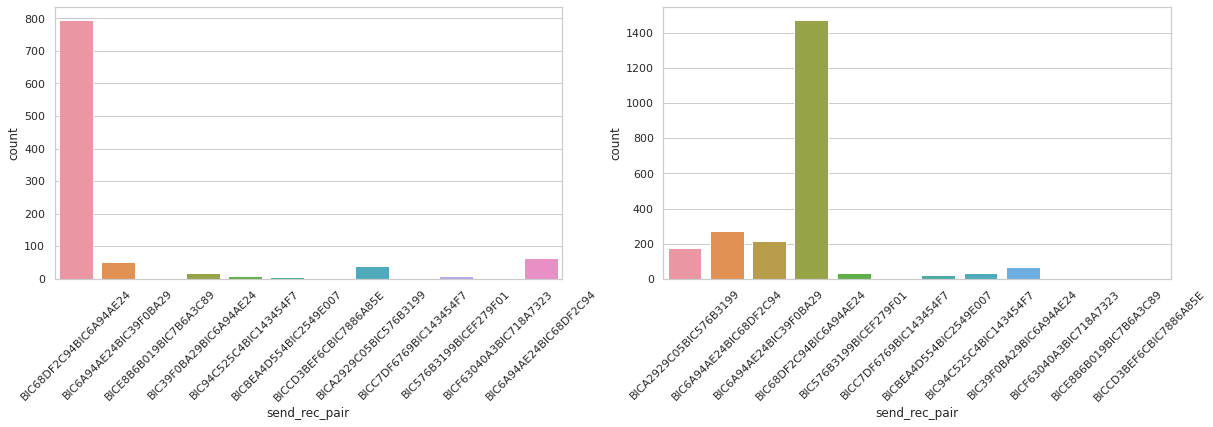

In [33]:
attr_plot(df, samples_a, discrete = discrete)

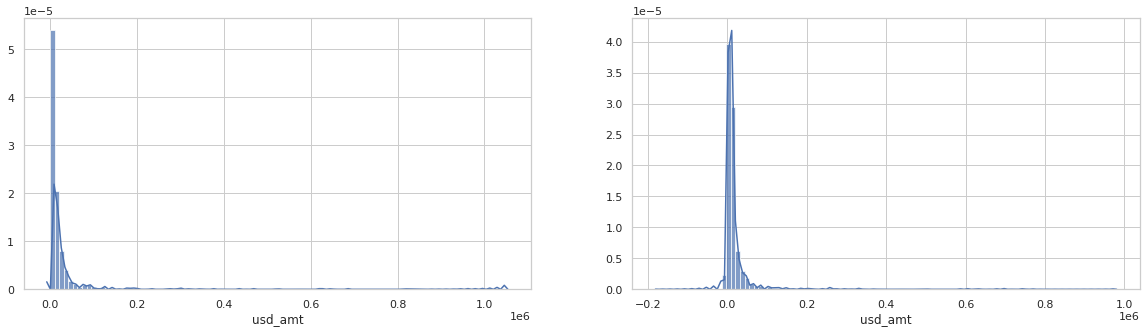

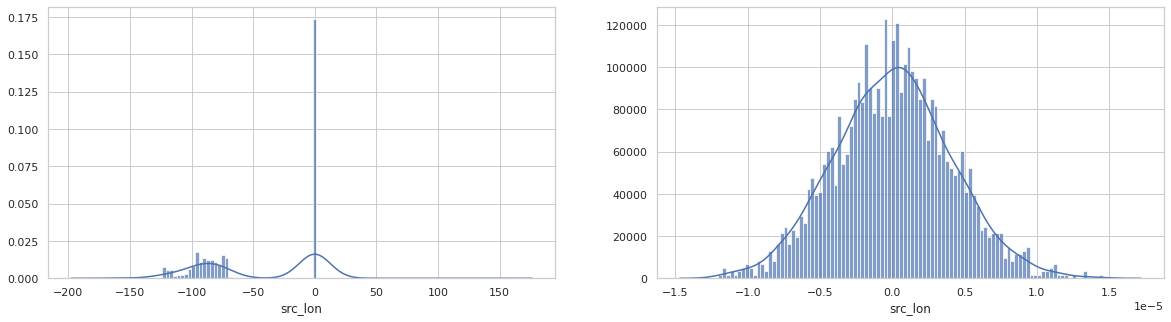

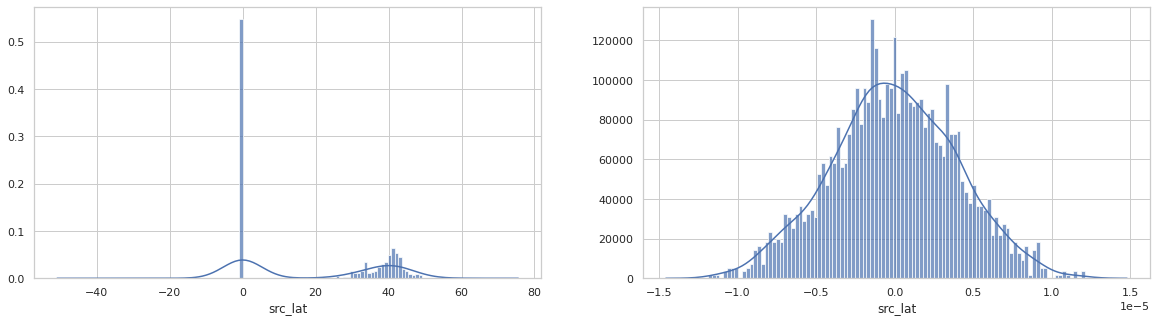

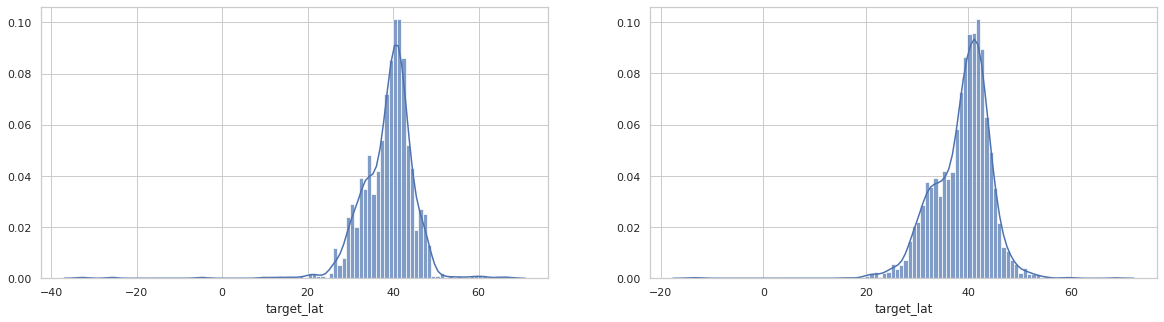

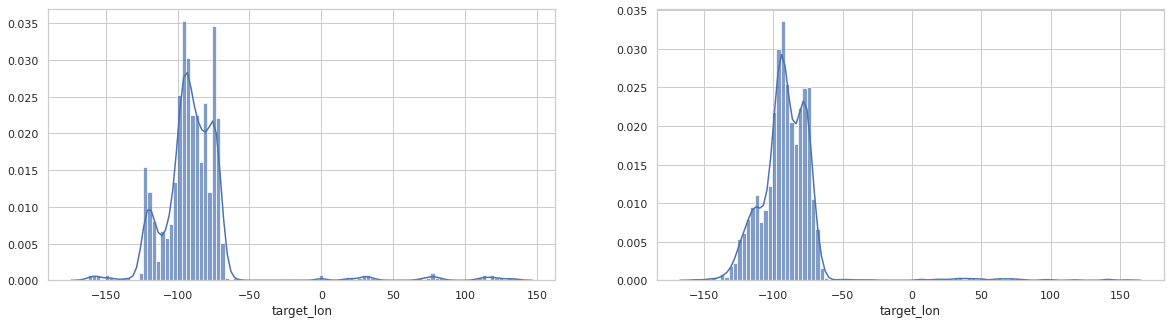

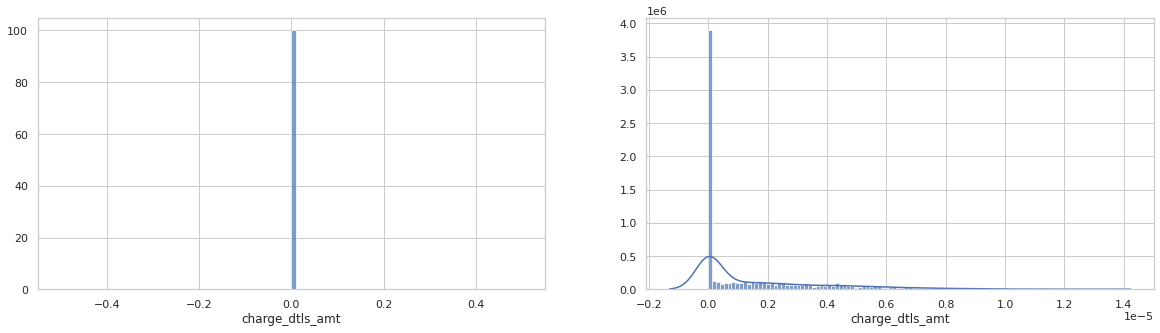

In [34]:
attr_plot(df, samples_a, numeric = numeric)

In [35]:
datan = DataAnalyser(df, samples_a)

##### Currency distribution in top 100 transactions

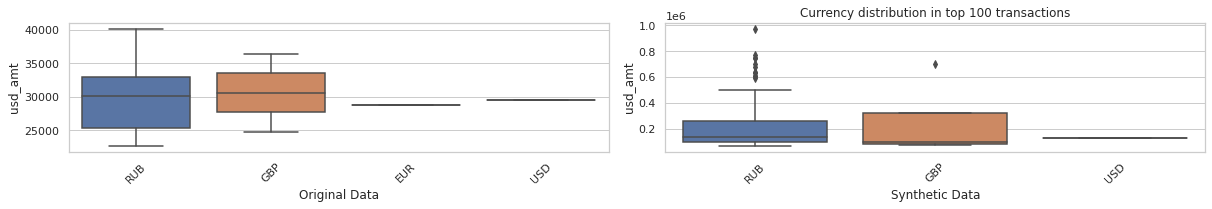

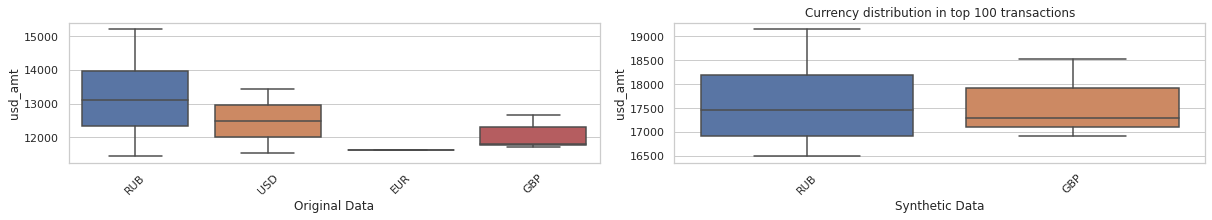

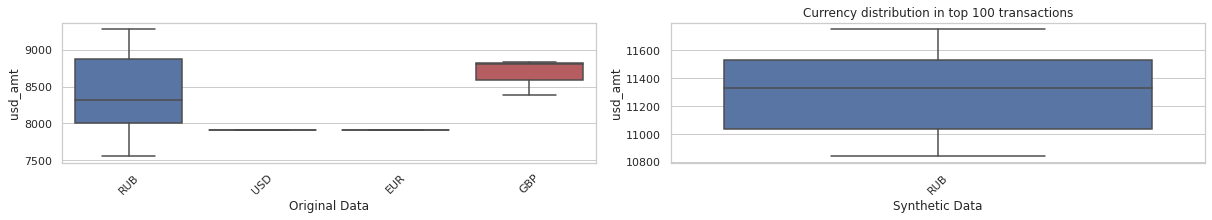

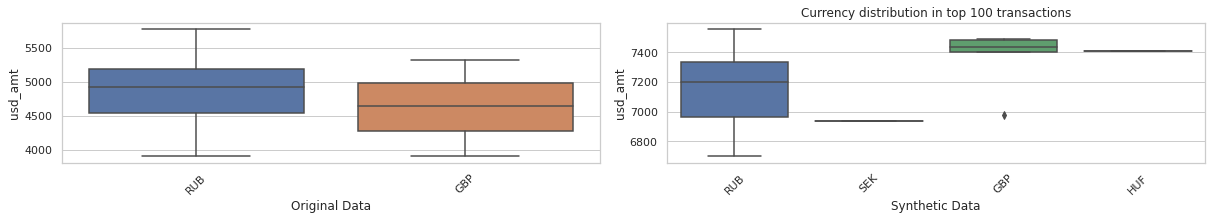

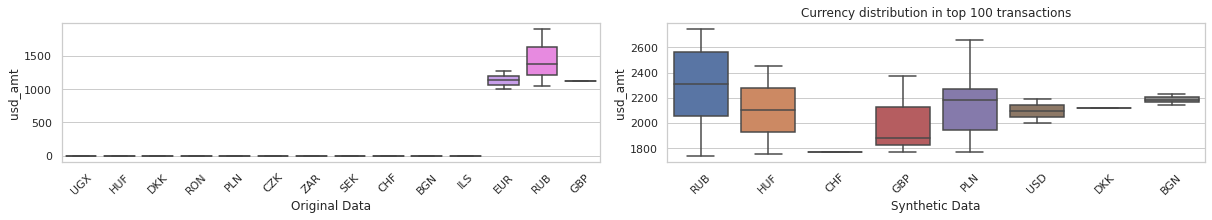

In [36]:
datan.plot_transaction_distribution(bins = 5, value_col = 'usd_amt', top_n = 100)

#### Top transactions hotspots

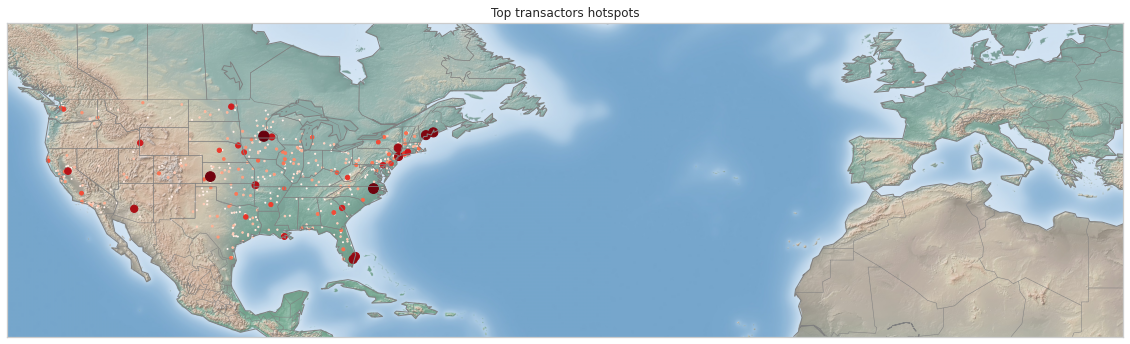

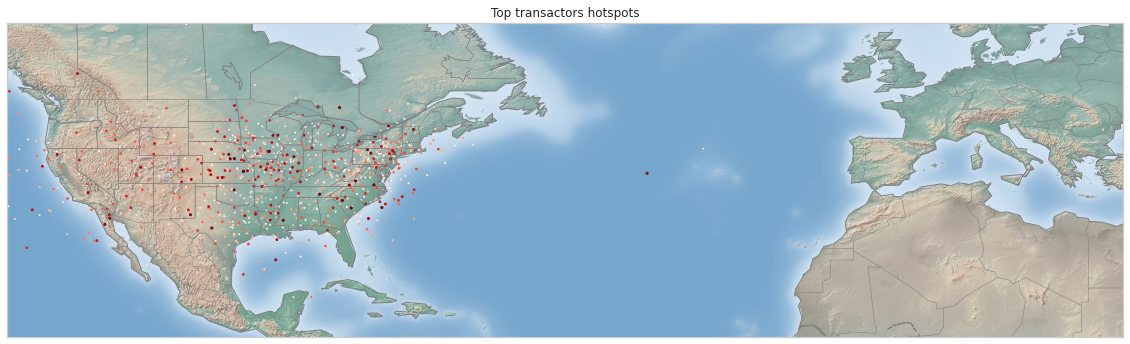

In [37]:
# original data comes first followed by the synthetically generated data
lower_bound_percentile = 0.5 
datan.plot_analysis(lower = lower_bound_percentile, transactor = 'target', value_col = 'usd_amt')

##### PCA Analysis

In [47]:
cov_samples_xa = samples_xa[0].T.dot(samples_xa[0])
Us, ss, Vts = np.linalg.svd(cov_samples_xa)

In [49]:
cov_data_xa = data_xa.T.dot(data_xa)
Ud, sd, Vtd = np.linalg.svd(cov_data_xa)

##### Cosine similarity between top principal components

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

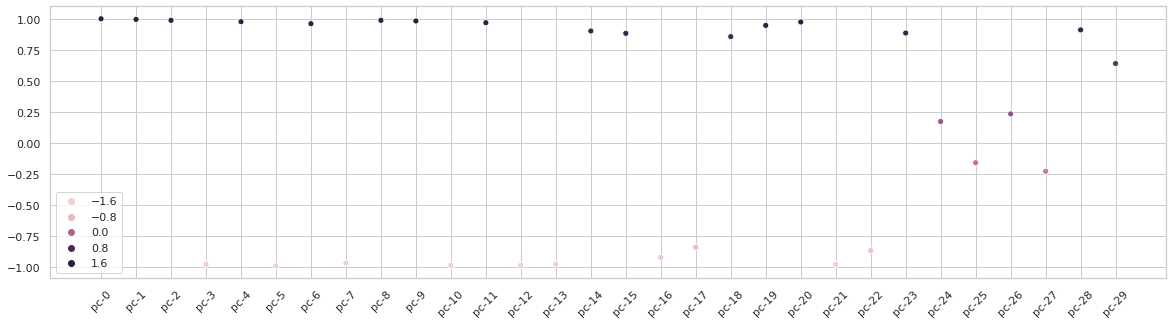

In [54]:
## Check cosine similarity between principal components
n_components = 30
x = ['pc-'+str(i) for i in range(n_components)]
y = [Us[:, i].dot(Ud[:, i]) for i in range(n_components)]

plt.figure(figsize=(20, 5))
sns.scatterplot(x, y, hue=y)
plt.xticks(rotation=45)

#### Merge two datasets and transform into MT103 format
Attributes (Account Numbers, Account Names, Strret Addresses) has been anonymised using `faker` library

In [38]:
final_fk = pd.DataFrame()

In [39]:
%%time
final_fk = convert_to_mt103(samples_fk, final_fk)

Generating fake list for 50A
Generating fake list for 50F
Generating fake list for 50k
Generating fake list for 59F
CPU times: user 15.7 s, sys: 2.37 s, total: 18.1 s
Wall time: 18.1 s


In [40]:
final_a = pd.DataFrame()

In [41]:
%%time
final_a = convert_to_mt103(samples_a, final_a)

Generating fake list for 50A
Generating fake list for 50F
Generating fake list for 50k
Generating fake list for 59F
CPU times: user 3.4 s, sys: 473 ms, total: 3.88 s
Wall time: 3.88 s


In [42]:
pd.concat([final_fk, final_a]).to_csv('data/final_output.csv', index=False)

In [55]:
pd.concat([final_fk, final_a])

,Sender,Receiver,:20:,:23B:,:32A:,:33B:,:36:,:50A:,:50F:,:50K:,:52A:,:56A:,:57A:,:59F:,:71A:,:71F:
0,BIC6A94A,BIC68DF2,FIN001-NO-FX-679,CRED,210924RUB3454259.6842184654,RUB3454259.6842184654,None,0 /000000000000000000000000000003\nBIC6A...,DRLC/US/VA/000000820\n 1/Robert Carson\n 2/994...,/000000000000000000000000000000409\n 1/David J...,BIC6A94AE24,None,BIC68DF2C94,/000000000000000000000000000000451\n 1/Samuel ...,OUR,9990.0
1,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB4055965.965198388,RUB4055965.965198388,None,0 /000000000000000000000000000002\nBIC6A...,DRLC/US/VA/000000109\n 1/Ruben Lewis\n 2/62516...,/000000000000000000000000000000814\n 1/Michell...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000971\n 1/Michael...,OUR,9997.766449097305114e-06
2,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB2771545.7326693083,RUB2771545.7326693083,None,0 /000000000000000000000000000002\nBIC6A...,DRLC/US/VA/000000342\n 1/Joshua Wolfe\n 2/Unit...,/000000000000000000000000000000977\n 1/William...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000999\n 1/Richard...,OUR,9990.0
3,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB5342007.655595176,RUB5342007.655595176,None,0 /000000000000000000000000000000\nBIC6A...,DRLC/US/VA/000000520\n 1/Rodney Gibbs\n 2/273 ...,/000000000000000000000000000000639\n 1/Michael...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000962\n 1/Kenneth...,OUR,9990.0
4,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB1869387.5308104677,RUB1869387.5308104677,None,0 /000000000000000000000000000000\nBIC6A...,DRLC/US/VA/000000467\n 1/Kylie Watts\n 2/Unit ...,/000000000000000000000000000000793\n 1/Anthony...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000293\n 1/Eric Su...,SHA,9990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB1440349.5405296853,RUB1440349.5405296853,None,0 /000000000000000000000000000002\nBICA2...,DRLC/US/VA/000000478\n 1/William Richardson\n ...,/000000000000000000000000000000353\n 1/Mallory...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000578\n 1/Michele...,BEN,RUB1.99165734707332e-06
2296,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB309431.3449587547,RUB309431.3449587547,None,0 /000000000000000000000000000000\nBICA2...,DRLC/US/VA/000000196\n 1/Ashley Phillips\n 2/6...,/000000000000000000000000000000141\n 1/Kathy R...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000435\n 1/Laura B...,BEN,RUB0.0
2297,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB314709.66914618335,RUB314709.66914618335,None,0 /000000000000000000000000000000\nBICA2...,DRLC/US/VA/000000283\n 1/Kent Romero\n 2/5491 ...,/0000000000000000000000000000007\n 1/Brandon S...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000279\n 1/Angela ...,BEN,RUB8.889437762481281e-06
2298,BIC68DF2,BIC6A94A,FIN001-NO-FX-679,CRED,210924RUB1314045.385940664,RUB1314045.385940664,None,0 /000000000000000000000000000003\nBICA2...,DRLC/US/VA/000000304\n 1/Whitney Beck\n 2/591 ...,/000000000000000000000000000000550\n 1/Doris F...,BIC68DF2C94,None,BIC6A94AE24,/000000000000000000000000000000895\n 1/Christo...,BEN,RUB0.0
